# Assignment 3: Recurrent Neural Networks for Stock Price Prediction
Shan Shan Bianca Tan (a1909709)

## 1. Download dataset
I first imported the dataset and the essential libraries required for the assignment. The dataset is from github. 

The link can be found here: https://github.com/ChZPan/stock-market-prediction-RNN/tree/master

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.initializers import GlorotUniform, HeNormal
import keras_tuner as kt

%matplotlib inline

# Set random seed for reproducibility
seed = 20
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# List all files in the "stock-market-data" directory
data_dir = "github-stock-market-data"
files = os.listdir(data_dir)
print(files)

['2013-2015.txt', '2010.4.1-2012.12.31.txt', '2015-2017.txt', '2017-2019.4.29.txt']


In [3]:
# List to hold each DataFrame
dataframes_list = []

# Define column names
column_names = ['date', 'time', 'open', 'close']

# Read each file and add to the list
for file_name in files:
    file_path = os.path.join(data_dir, file_name)
    # Read the file with specified delimiter, assuming comma-separated for now
    df = pd.read_csv(file_path, delimiter=r'\s+', header=None)
    df.columns = column_names  # Assign column names
    dataframes_list.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
full_df = pd.concat(dataframes_list, ignore_index=True)

# Convert 'date' and 'time' to a datetime column
full_df['datetime'] = pd.to_datetime(full_df['date'] + ' ' + full_df['time'], format='%Y/%m/%d %H:%M:%S')

# Sort the DataFrame by the 'datetime' column
full_df.sort_values(by='datetime', inplace=True)

# Reset the index after sorting
full_df.reset_index(drop=True, inplace=True)

# Drop the datetime column
full_df.drop(columns=['datetime'], inplace=True)

# Display the shape and first few rows of the merged DataFrame
print(f"DataFrame shape: {full_df.shape}")
print(full_df.head())

DataFrame shape: (105830, 4)
         date      time     open    close
0  2010/04/01  09:35:00  3345.61  3359.57
1  2010/04/01  09:40:00  3359.83  3368.12
2  2010/04/01  09:45:00  3368.76  3371.16
3  2010/04/01  09:50:00  3370.86  3369.15
4  2010/04/01  09:55:00  3369.08  3373.68


In [4]:
# Print the dataframe to check
full_df

,date,time,open,close
0,2010/04/01,09:35:00,3345.61,3359.57
1,2010/04/01,09:40:00,3359.83,3368.12
2,2010/04/01,09:45:00,3368.76,3371.16
3,2010/04/01,09:50:00,3370.86,3369.15
4,2010/04/01,09:55:00,3369.08,3373.68
...,...,...,...,...
105825,2019/04/29,09:35:00,3896.58,3889.65
105826,2019/04/29,09:40:00,3889.61,3904.17
105827,2019/04/29,09:45:00,3904.58,3878.74
105828,2019/04/29,09:50:00,3878.20,3890.37


## 2. Exploratory Data Analysis
Here, I explored the chosen dataset.

In [5]:
print(f"Total rows: {len(full_df)}")

Total rows: 105830


In [6]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105830 entries, 0 to 105829
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    105830 non-null  object 
 1   time    105830 non-null  object 
 2   open    105830 non-null  float64
 3   close   105830 non-null  float64
dtypes: float64(2), object(2)
memory usage: 3.2+ MB


The dataset contains stock price information from April 2010 to April 2019, with a total of **105,830 entries**. The four columns in the dataset are: date, time, open, and close. The open and close columns represent the stock prices at the beginning and end of each 5-minute interval, respectively.

In [7]:
full_df.describe().T

,count,mean,std,min,25%,50%,75%,max
open,105830.0,3088.681822,635.770809,2028.78,2518.6575,3137.76,3475.1500,5379.47
close,105830.0,3088.738670,635.779638,2029.25,2518.8425,3137.95,3475.1475,5374.70


I explored the price change between the open and closing prices using the following formula:
$$
\text{Price Change} = (\text{Close Price} - \text{Open Price})
$$


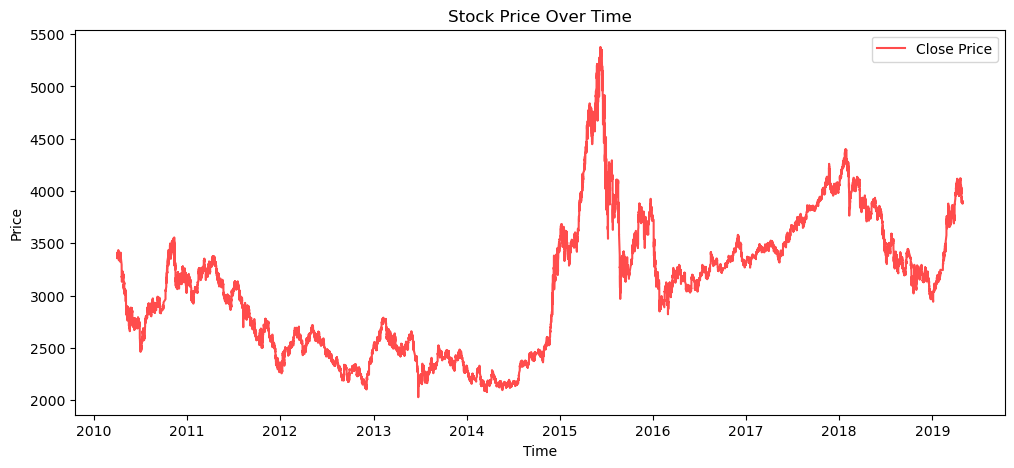

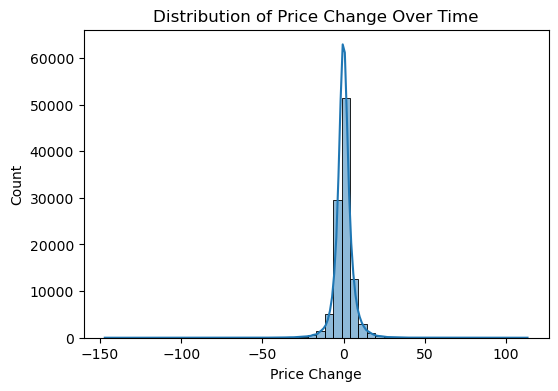

In [8]:
# Convert date and time to datetime for easier analysis
full_df['datetime'] = pd.to_datetime(full_df['date'] + ' ' + full_df['time'])

# Line plot of close prices over time
plt.figure(figsize=(12, 5))
plt.plot(full_df['datetime'], full_df['close'], label='Close Price', color='red', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Over Time')
plt.legend()
plt.savefig('stock_price_over_time.png', dpi=300)  # Save the plot
plt.show()

# Distribution of price changes
full_df['price_change'] = full_df['close'] - full_df['open']
plt.figure(figsize=(6, 4))
sns.histplot(full_df['price_change'], kde=True, bins=50)
plt.xlabel('Price Change')
plt.title('Distribution of Price Change Over Time')
plt.savefig('price_change_distribution.png', dpi=300)  # Save the plot
plt.show()


The distribution of price change follows a normal distribution with a higher frequency of small price changes, which suggest that stock prices are relatively stable. The market is steady with low volatility.

In [9]:
print('Before scaling:')
print(full_df.head())

# Initialize the StandardScaler
scaler = StandardScaler()

# Select the columns to scale
columns_to_scale = ['open', 'close']

# Scale the selected columns
scaled_values = scaler.fit_transform(full_df[columns_to_scale])

# Replace original columns with scaled values
full_df[columns_to_scale] = scaled_values

# Display the scaled DataFrame
print('After scaling:')
print(full_df.head())

Before scaling:
         date      time     open    close            datetime  price_change
0  2010/04/01  09:35:00  3345.61  3359.57 2010-04-01 09:35:00         13.96
1  2010/04/01  09:40:00  3359.83  3368.12 2010-04-01 09:40:00          8.29
2  2010/04/01  09:45:00  3368.76  3371.16 2010-04-01 09:45:00          2.40
3  2010/04/01  09:50:00  3370.86  3369.15 2010-04-01 09:50:00         -1.71
4  2010/04/01  09:55:00  3369.08  3373.68 2010-04-01 09:55:00          4.60
After scaling:
         date      time      open     close            datetime  price_change
0  2010/04/01  09:35:00  0.404123  0.425985 2010-04-01 09:35:00         13.96
1  2010/04/01  09:40:00  0.426489  0.439433 2010-04-01 09:40:00          8.29
2  2010/04/01  09:45:00  0.440535  0.444215 2010-04-01 09:45:00          2.40
3  2010/04/01  09:50:00  0.443838  0.441053 2010-04-01 09:50:00         -1.71
4  2010/04/01  09:55:00  0.441039  0.448178 2010-04-01 09:55:00          4.60


I scaled the data using StandardScaler. StandardScaler standardizes the data by centering it to a mean of 0 and scaling it to a standard deviation of 1. StandardScaler is less sensitive to outliers compared to MinMaxScaler which could compress the range of data if there are extreme values. In stock price data outliers do exist in cases of market crash or sudden spikes which makes StandardScaler a better choice in this case.

## 3. Model Training
In this section, I carried out hyper-parameter tuning and model training.

In [10]:
# Define sequence length
sequence_length = 10

# Create sequences
sequences = []
targets = []

for i in range(len(full_df) - sequence_length):
    seq = full_df[['open', 'close']].iloc[i:i + sequence_length].values
    target = full_df['close'].iloc[i + sequence_length]
    sequences.append(seq)
    targets.append(target)

# Convert to numpy arrays
X = np.array(sequences)
y = np.array(targets)

print("Input shape:", X.shape)  # (num_sequences, sequence_length, num_features)
print("Target shape:", y.shape)  # (num_sequences,)

Input shape: (105820, 10, 2)
Target shape: (105820,)


In [11]:
# Split into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (74074, 10, 2) (74074,)
Validation data shape: (15873, 10, 2) (15873,)
Testing data shape: (15873, 10, 2) (15873,)


In [12]:
# Initialize empty lists to store the results
models = []
validation_losses = []
validation_mae = []

### 3.1 Baseline Model

In [13]:
# Define the baseline Simple RNN model
def build_baseline_simple_rnn(input_shape):
    model = Sequential()
    
    # Add a Simple RNN layer with a fixed number of units
    model.add(SimpleRNN(units=128, input_shape=input_shape, stateful=False, unroll=True))
    
    # Add a dropout layer
    model.add(Dropout(0.3))
    
    # Add a fully connected dense layer with fixed units and ReLU activation
    model.add(Dense(32, activation='relu'))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile the model with Adam optimizer and Mean Squared Error loss for regression
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Build the baseline model using the input shape of your dataset (X_train.shape[1:])
input_shape = X_train.shape[1:] 
baseline_model = build_baseline_simple_rnn(input_shape)

# Train the baseline model
history_baseline = baseline_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=1)

# Evaluate the model on the validation set
val_loss, val_mae = baseline_model.evaluate(X_val, y_val)
print(f"\nBaseline Model -> Validation Loss: {val_loss}, Validation MAE: {val_mae}")

# Append the results to the corresponding lists
models.append('Baseline Model (Simple RNN)')
validation_losses.append(val_loss)
validation_mae.append(val_mae)

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2315/2315 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0163 - mae: 0.0747 - val_loss: 6.5496e-04 - val_mae: 0.0198
Epoch 2/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0043 - mae: 0.0445 - val_loss: 2.1354e-04 - val_mae: 0.0118
Epoch 3/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0035 - mae: 0.0402 - val_loss: 0.0017 - val_mae: 0.0396
Epoch 4/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0034 - mae: 0.0392 - val_loss: 6.0369e-04 - val_mae: 0.0233
Epoch 5/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0032 - mae: 0.0380 - val_loss: 1.2116e-04 - val_mae: 0.0092
Epoch 6/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0032 - mae: 0.0377 - val_loss: 1.3231e-04 - val_mae: 0.0094
Epoch 7/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 6.1531e-04 - val_mae: 0.0195
Epoch 8/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0029 - mae: 0.0356 - val_loss: 1.2532e-04 - val_mae: 0.0090
Epoch 9/30
2315/2315 ━━

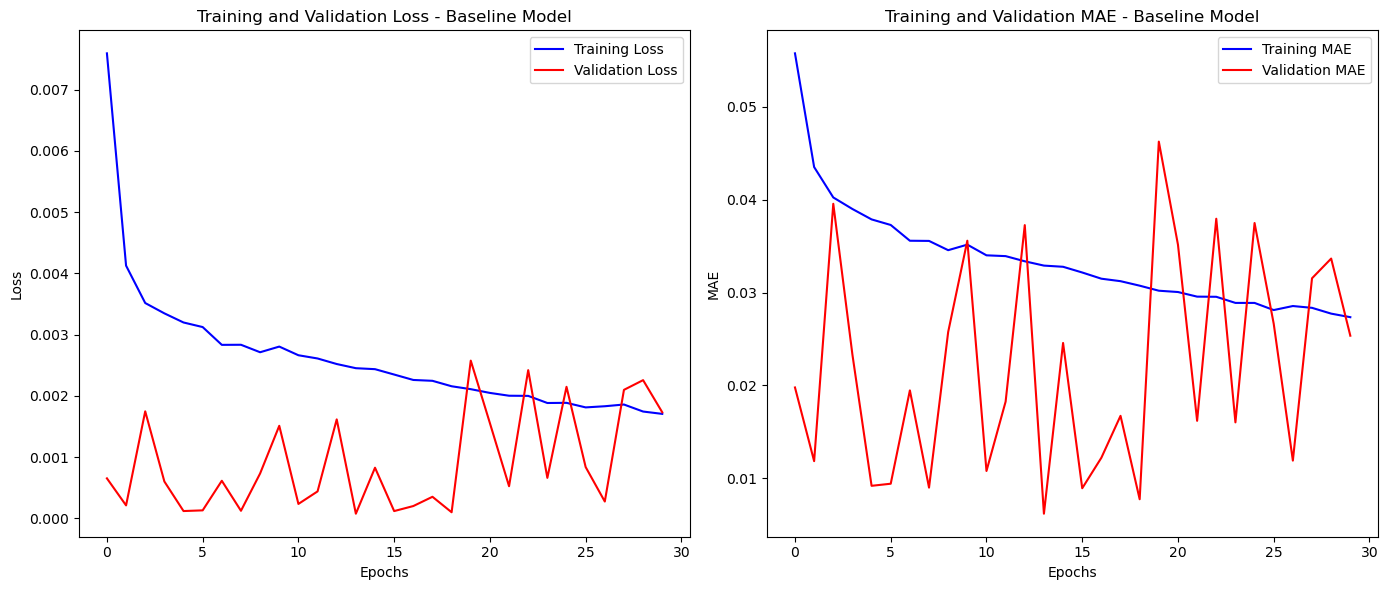

In [14]:
# Extract loss and metrics from the history object
train_loss_baseline = history_baseline.history['loss']
val_loss_baseline = history_baseline.history['val_loss']
train_mae_baseline = history_baseline.history['mae']
val_mae_baseline = history_baseline.history['val_mae']

# Create a figure with 2 subplots side by side 
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the loss
axs[0].plot(train_loss_baseline, label='Training Loss', color='blue')
axs[0].plot(val_loss_baseline, label='Validation Loss', color='red')
axs[0].set_title('Training and Validation Loss - Baseline Model')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the MAE
axs[1].plot(train_mae_baseline, label='Training MAE', color='blue')
axs[1].plot(val_mae_baseline, label='Validation MAE', color='red')
axs[1].set_title('Training and Validation MAE - Baseline Model')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend()

# Display the plot
plt.tight_layout()
plt.savefig('baseline_model_performance.png')  # Save the figure
plt.show()

### 3.2 Hyper-parameter Tuning

#### 3.2.1 Simple RNN

##### Step 1: Define the Model-Building Function

In [15]:
# Step 1: Define the model-building function
def build_simple_rnn_model(hp):
    model = Sequential()
    
    # Tune the number of units in the RNN layer
    model.add(SimpleRNN(units=hp.Int('units', min_value=64, max_value=256, step=64),
                        input_shape=(X_train.shape[1], X_train.shape[2]),
                        stateful=False, unroll=True))
    
    # Tune dropout rate
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Fully connected layer
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    
    # Output layer
    model.add(Dense(1))
    
    # Tune learning rate
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

##### Step 2: Set Up the Tuner and Run the Search

In [16]:
# Step 2: Instantiate the Tuner with max_trials inside Hyperband
tuner = kt.Hyperband(
    build_simple_rnn_model,
    objective='val_loss',
    max_epochs=10,
    hyperband_iterations=2,
    directory='rnn_tuning',
    project_name='rnn_hyperparameter_search',
    executions_per_trial=1  # Optional, you can adjust how many times each trial is executed
)

# Set max_trials by creating the `Hyperband` tuner to use your desired number
tuner.oracle.max_trials = 20  # Set max_trials here

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), seed=seed)

Reloading Tuner from rnn_tuning/rnn_hyperparameter_search/tuner0.json


##### Step 3: Retrieve the Best Hyperparameters

In [17]:
# Step 3: Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters.values)

# Extract specific hyperparameter values
units = best_hyperparameters.get('units')
dropout_rate = best_hyperparameters.get('dropout')
dense_units = best_hyperparameters.get('dense_units')
learning_rate = best_hyperparameters.get('learning_rate')

# Print out the best validation loss as well
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"\nBest validation loss: {best_trial.score}")


Best Hyperparameters: {'units': 256, 'dropout': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.00022495397713513603, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}

Best validation loss: 4.2307725379941985e-05


/opt/anaconda3/lib/python3.12/site-packages/keras_tuner/src/tuners/hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##### Step 4: Build and Train the Model with the Best Hyperparameters

In [18]:
# Step 4: Build the model using the best hyperparameters
def build_rnn_model_with_hyperparameters(input_shape, units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(SimpleRNN(units=units, 
                        input_shape=input_shape, 
                        unroll=True, 
                        stateful=False))  # Set stateful=False unless explicitly needed
    model.add(Dropout(dropout_rate))  # Use the dropout rate from hyperparameters
    model.add(Dense(32, activation='relu'))  # Fully connected layer
    model.add(Dense(1))  # Output layer
    
    optimizer = Adam(learning_rate=learning_rate)  # Use the learning rate from hyperparameters
    model.compile(optimizer=optimizer, 
                  loss='mse', 
                  metrics=['mae'])
    return model

# Build the model with best hyperparameters
model = build_rnn_model_with_hyperparameters(X_train.shape[1:], 
                                             best_hyperparameters.get('units'), 
                                             best_hyperparameters.get('dropout'), 
                                             best_hyperparameters.get('learning_rate'))


history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=30, batch_size=32, verbose=1)

Epoch 1/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0229 - mae: 0.0773 - val_loss: 0.0027 - val_mae: 0.0491
Epoch 2/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0034 - mae: 0.0396 - val_loss: 8.8193e-04 - val_mae: 0.0274
Epoch 3/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0028 - mae: 0.0357 - val_loss: 6.0806e-04 - val_mae: 0.0235
Epoch 4/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0025 - mae: 0.0337 - val_loss: 4.8064e-05 - val_mae: 0.0051
Epoch 5/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0023 - mae: 0.0324 - val_loss: 1.5771e-04 - val_mae: 0.0109
Epoch 6/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0021 - mae: 0.0313 - val_loss: 6.9751e-05 - val_mae: 0.0060
Epoch 7/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0020 - mae: 0.0298 - val_loss: 1.7050e-04 - val_mae: 0.0113
Epoch 8/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0019 - mae: 0.0292 - val_loss: 1.1377e-04 - val_mae: 0.0091
Epoch 9/30
2

##### Step 5: Evaluate and Visualize

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4333e-05 - mae: 0.0046
Validation Loss: 0.00013122271047905087, Validation MAE: 0.0077501945197582245


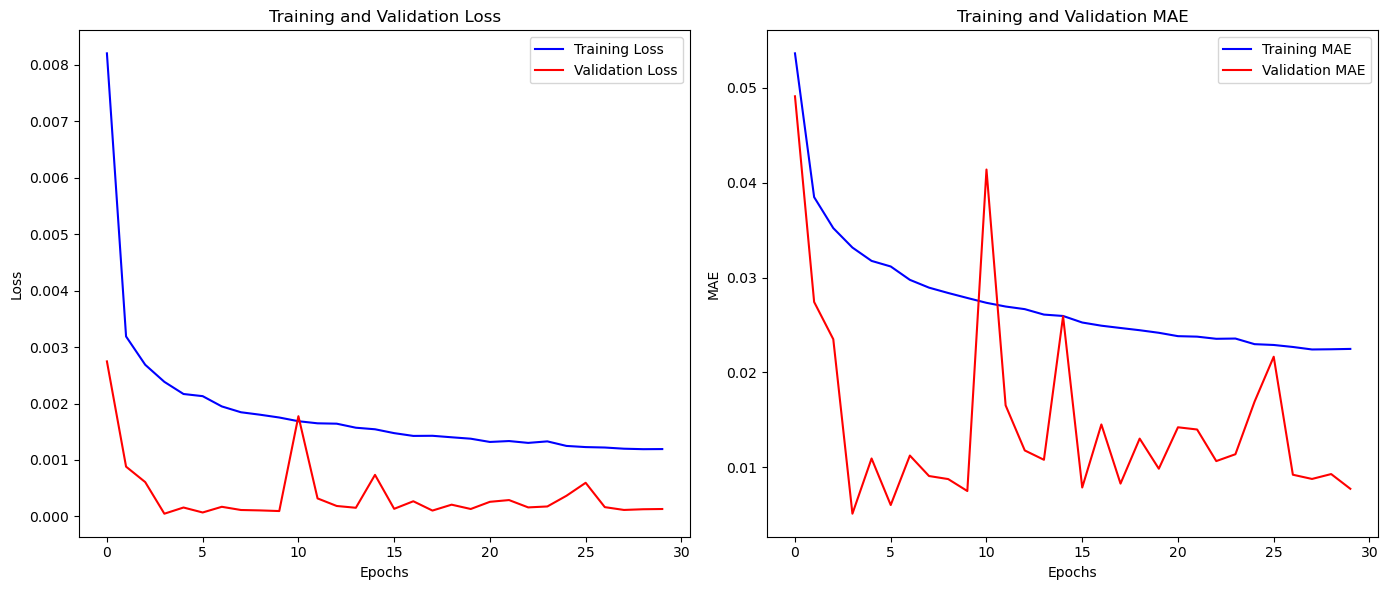

In [19]:
# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

# Append the results to the corresponding lists
models.append('Simple RNN')
validation_losses.append(val_loss)
validation_mae.append(val_mae)

# Extract loss and metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# If you are tracking RMSE, you can do this:
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Create a figure with 2 subplots side by side (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plotting the loss
axs[0].plot(train_loss, label='Training Loss', color='blue')
axs[0].plot(val_loss, label='Validation Loss', color='red')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the MAE
axs[1].plot(train_mae, label='Training MAE', color='blue')
axs[1].plot(val_mae, label='Validation MAE', color='red')
axs[1].set_title('Training and Validation MAE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend()

# Display the plot
plt.tight_layout()
plt.savefig('simple_rnn_model_performance.png')  # Save the figure
plt.show()


#### 3.2.2 LSTM 

##### Step 1: Define the Model-Building Function¶

In [20]:
def build_lstm_model(hp):
    model = Sequential()
    
    # Tune the number of units in the LSTM layer
    model.add(LSTM(units=hp.Int('units', min_value=64, max_value=256, step=64),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   stateful=False, unroll=True))
    
    # Tune dropout rate
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Fully connected layer
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    
    # Output layer
    model.add(Dense(1))
    
    # Tune learning rate
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


##### Step 2: Set Up the Tuner and Run the Search

In [21]:
tuner = kt.Hyperband(
    build_lstm_model,
    objective='val_loss',
    max_epochs=10,
    hyperband_iterations=2,
    directory='lstm_tuning',
    project_name='lstm_hyperparameter_search',
    executions_per_trial=1
)

# Limit the number of trials
tuner.oracle.max_trials = 20

# Start the hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, seed=seed)

Reloading Tuner from lstm_tuning/lstm_hyperparameter_search/tuner0.json


##### Step 3: Retrieve the Best Hyperparameters

In [22]:
# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:", best_hyperparameters.values)

# Extract specific hyperparameter values
units = best_hyperparameters.get('units')
dropout_rate = best_hyperparameters.get('dropout')
dense_units = best_hyperparameters.get('dense_units')
learning_rate = best_hyperparameters.get('learning_rate')

best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"\nBest validation loss: {best_trial.score}")

Best Hyperparameters: {'units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.00027523785246150276, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0, 'dropout': 0.2, 'dense_units': 32}

Best validation loss: 5.87220310990233e-05


##### Step 4: Build and Train the Model with the Best Hyperparameters

In [23]:
def build_lstm_model_with_hyperparameters(input_shape, units, dropout_rate, dense_units, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape, unroll=True, stateful=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Build and train the model
model = build_lstm_model_with_hyperparameters(X_train.shape[1:], units, dropout_rate, dense_units, learning_rate)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0356 - mae: 0.0839 - val_loss: 3.2172e-04 - val_mae: 0.0145
Epoch 2/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0029 - mae: 0.0362 - val_loss: 8.3534e-04 - val_mae: 0.0261
Epoch 3/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0024 - mae: 0.0326 - val_loss: 6.8166e-04 - val_mae: 0.0238
Epoch 4/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0020 - mae: 0.0296 - val_loss: 1.7335e-04 - val_mae: 0.0107
Epoch 5/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0018 - mae: 0.0276 - val_loss: 2.5245e-04 - val_mae: 0.0134
Epoch 6/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0016 - mae: 0.0254 - val_loss: 5.7425e-05 - val_mae: 0.0055
Epoch 7/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0014 - mae: 0.0239 - val_loss: 5.6798e-05 - val_mae: 0.0055
Epoch 8/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0014 - mae: 0.0228 - val_loss: 6.0549e-04 - val_mae: 0.0205
Epoch 9

##### Step 5: Evaluate and Visualize

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - mae: 0.0297
Validation Loss: 0.001795173273421824, Validation MAE: 0.034966569393873215


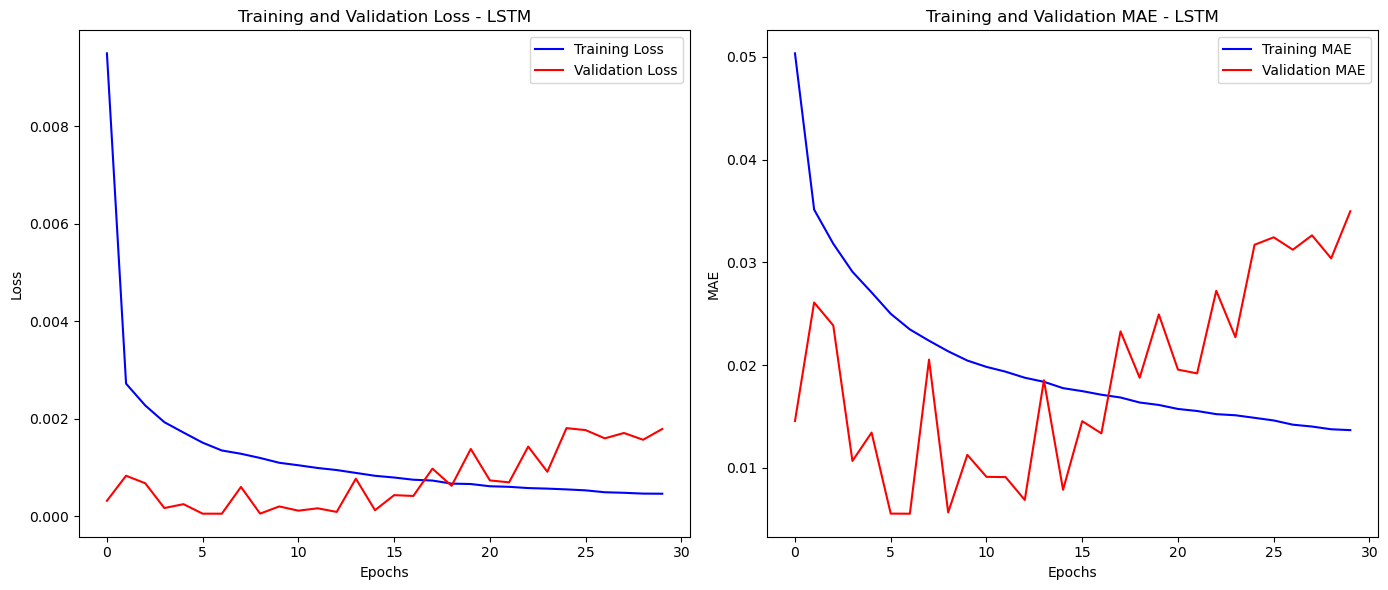

In [24]:
# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

# Append the results to the corresponding lists
models.append('LSTM')
validation_losses.append(val_loss)
validation_mae.append(val_mae)

# Extract loss and metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Create a figure with 2 subplots side by side (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plotting the loss
axs[0].plot(train_loss, label='Training Loss', color='blue')
axs[0].plot(val_loss, label='Validation Loss', color='red')
axs[0].set_title('Training and Validation Loss - LSTM')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the MAE
axs[1].plot(train_mae, label='Training MAE', color='blue')
axs[1].plot(val_mae, label='Validation MAE', color='red')
axs[1].set_title('Training and Validation MAE - LSTM')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend()

# Save the plot as a PNG file
plt.tight_layout()  # Automatically adjust the subplot parameters for better spacing
plt.savefig('lstm_model_performance.png')  # Save the figure

# Optionally, display the plot
plt.show()

#### 3.2.3 GRU

##### Step 1: Define the Model-Building Function

In [25]:
def build_gru_model(hp):
    model = Sequential()
    
    # Tune the number of units in the GRU layer
    model.add(GRU(units=hp.Int('units', min_value=64, max_value=256, step=64),
                  input_shape=(X_train.shape[1], X_train.shape[2]),
                  stateful=False, unroll=True))
    
    # Tune dropout rate
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Fully connected layer
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    
    # Output layer
    model.add(Dense(1))
    
    # Tune learning rate
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


##### Step 2: Set Up the Tuner and Run the Search

In [26]:
tuner = kt.Hyperband(
    build_gru_model,
    objective='val_loss',
    max_epochs=10,
    hyperband_iterations=2,
    directory='gru_tuning',
    project_name='gru_hyperparameter_search',
    executions_per_trial=1
)

# Limit the number of trials for practical purposes
tuner.oracle.max_trials = 20

# Start the hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, seed=seed)

Reloading Tuner from gru_tuning/gru_hyperparameter_search/tuner0.json


##### Step 3: Retrieve the Best Hyperparameters

In [27]:
# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:", best_hyperparameters.values)

# Extract specific hyperparameter values
units = best_hyperparameters.get('units')
dropout_rate = best_hyperparameters.get('dropout')
dense_units = best_hyperparameters.get('dense_units')
learning_rate = best_hyperparameters.get('learning_rate')

best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
print(f"\nBest validation loss: {best_trial.score}")

Best Hyperparameters: {'units': 192, 'dropout': 0.30000000000000004, 'dense_units': 32, 'learning_rate': 4.726958527232858e-05, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '13'}

Best validation loss: 5.7603065215516835e-05


##### Step 4: Build and Train the Model with the Best Hyperparameters

In [28]:
def build_gru_model_with_hyperparameters(input_shape, units, dropout_rate, dense_units, learning_rate):
    model = Sequential()
    model.add(GRU(units=units, input_shape=input_shape, unroll=True, stateful=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Build and train the model
model = build_gru_model_with_hyperparameters(X_train.shape[1:], units, dropout_rate, dense_units, learning_rate)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.1126 - mae: 0.1672 - val_loss: 2.1708e-04 - val_mae: 0.0123
Epoch 2/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0054 - mae: 0.0488 - val_loss: 4.5872e-04 - val_mae: 0.0189
Epoch 3/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0036 - mae: 0.0405 - val_loss: 1.5233e-04 - val_mae: 0.0097
Epoch 4/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0029 - mae: 0.0368 - val_loss: 1.2425e-04 - val_mae: 0.0087
Epoch 5/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0027 - mae: 0.0352 - val_loss: 1.0247e-04 - val_mae: 0.0079
Epoch 6/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0025 - mae: 0.0339 - val_loss: 1.1530e-04 - val_mae: 0.0084
Epoch 7/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0023 - mae: 0.0329 - val_loss: 1.9068e-04 - val_mae: 0.0104
Epoch 8/30
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0023 - mae: 0.0322 - val_loss: 9.1943e-05 - val_mae: 0.0076


##### Step 5: Evaluate and Visualize

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.6148e-05 - mae: 0.0049
Validation Loss: 0.00010938412742689252, Validation MAE: 0.007398319896310568


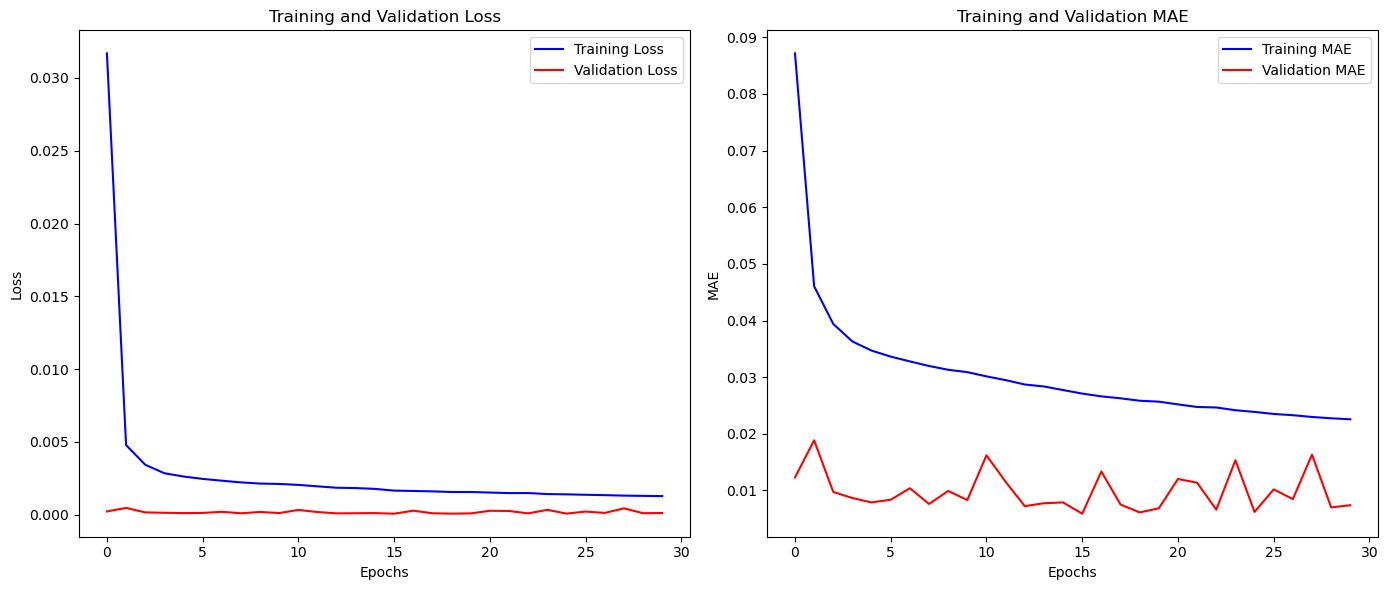

In [29]:
# Evaluate the model
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")

# Append the results to the corresponding lists
models.append('GRU')
validation_losses.append(val_loss)
validation_mae.append(val_mae)

# Extract loss and metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Create a figure with 2 subplots side by side (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plotting the loss
axs[0].plot(train_loss, label='Training Loss', color='blue')
axs[0].plot(val_loss, label='Validation Loss', color='red')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the MAE
axs[1].plot(train_mae, label='Training MAE', color='blue')
axs[1].plot(val_mae, label='Validation MAE', color='red')
axs[1].set_title('Training and Validation MAE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend()

# Display the plot
plt.tight_layout()  # Automatically adjust the subplot parameters for better spacing
plt.savefig('gru_model_performance.png')  # Save the figure
plt.show()

#### 3.2.4 Comparison of Validation Results

In [30]:
# Create a summary with the saved results from the above models
results = list(zip(models, validation_losses, validation_mae))

# Displaying results
for model, loss, mae in results:
    print(f"{model} -> Validation Loss: {loss}, Validation MAE: {mae}")

# Identify the best model based on validation loss
best_model_index = validation_losses.index(min(validation_losses))
print(f"\nBest model is: {models[best_model_index]}")

Baseline Model (Simple RNN) -> Validation Loss: 0.001733461394906044, Validation MAE: 0.025357143953442574
Simple RNN -> Validation Loss: 0.00013122271047905087, Validation MAE: 0.0077501945197582245
LSTM -> Validation Loss: 0.001795173273421824, Validation MAE: 0.034966569393873215
GRU -> Validation Loss: 0.00010938412742689252, Validation MAE: 0.007398319896310568

Best model is: GRU


### 4 Final Model Training and Evaluation (Training, Validation and Testing)

In [32]:
# Best hyperparameters based on the above results
best_params = {'units': 192, 
               'dropout': 0.30000000000000004, 
               'dense_units': 32, 
               'learning_rate': 4.726958527232858e-05, 
               'tuner/epochs': 10, 
               'tuner/initial_epoch': 4, 
               'tuner/bracket': 2, 
               'tuner/round': 2, 
               'tuner/trial_id': '13'}

In [33]:
# Define the GRU model with the best hyperparameters
def build_gru_model(input_shape, units=192, dropout_rate=0.3, dense_units=32, learning_rate=4.726958527232858e-05):
    model = Sequential()
    
    # Add a GRU layer with specified units
    model.add(GRU(units=units, input_shape=input_shape, return_sequences=False))
    
    # Add a Dropout layer
    model.add(Dropout(dropout_rate))
    
    # Add a Dense layer
    model.add(Dense(dense_units, activation='relu'))
    
    # Output layer (assuming regression)
    model.add(Dense(1))  # Adjust if classification
    
    # Compile the model with the Adam optimizer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Assuming X_train, y_train, X_val, y_val are already defined
input_shape = X_train.shape[1:]
gru_model = build_gru_model(input_shape, 
                            units=best_params['units'],
                            dropout_rate=best_params['dropout'],
                            dense_units=best_params['dense_units'],
                            learning_rate=best_params['learning_rate'])

# Train the model
history_gru = gru_model.fit(X_train, y_train, 
                            validation_data=(X_val, y_val),
                            epochs=50, 
                            batch_size=32, 
                            initial_epoch=0,
                            verbose=1)


# Evaluate the model
val_loss, val_mae = gru_model.evaluate(X_val, y_val, verbose=0)
test_loss, test_mae = gru_model.evaluate(X_test, y_test, verbose=0)

# Make predictions on the test set
y_pred = gru_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Validation Loss: {val_loss}, Validation MAE: {val_mae}")
print(f"\nTest Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {rmse}")

# Evaluate the model on the validation set
#val_loss, val_mae = gru_model.evaluate(X_val, y_val)
#print(f"\nGRU Model -> Validation Loss: {val_loss}, Validation MAE: {val_mae}")

# Test the model on the test set (if available)
#test_loss, test_mae = gru_model.evaluate(X_test, y_test)
# Make predictions on the test set
#y_pred = gru_model.predict(X_test)

# Calculate RMSE and MAE for the test set predictions
#from sklearn.metrics import mean_squared_error, mean_absolute_error

#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#mae = mean_absolute_error(y_test, y_pred)

#print(f"\nTest Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {rmse}")

Epoch 1/50
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.1394 - mae: 0.1794 - val_loss: 4.5974e-04 - val_mae: 0.0184
Epoch 2/50
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0052 - mae: 0.0480 - val_loss: 1.6706e-04 - val_mae: 0.0102
Epoch 3/50
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0036 - mae: 0.0401 - val_loss: 1.4318e-04 - val_mae: 0.0093
Epoch 4/50
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0029 - mae: 0.0366 - val_loss: 1.5698e-04 - val_mae: 0.0099
Epoch 5/50
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0026 - mae: 0.0347 - val_loss: 8.3506e-05 - val_mae: 0.0069
Epoch 6/50
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0024 - mae: 0.0334 - val_loss: 4.9079e-04 - val_mae: 0.0176
Epoch 7/50
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0023 - mae: 0.0325 - val_loss: 1.0026e-04 - val_mae: 0.0079
Epoch 8/50
2315/2315 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0022 - mae: 0.0318 - val_loss: 9.8689e-05 - val_mae: 0.0079


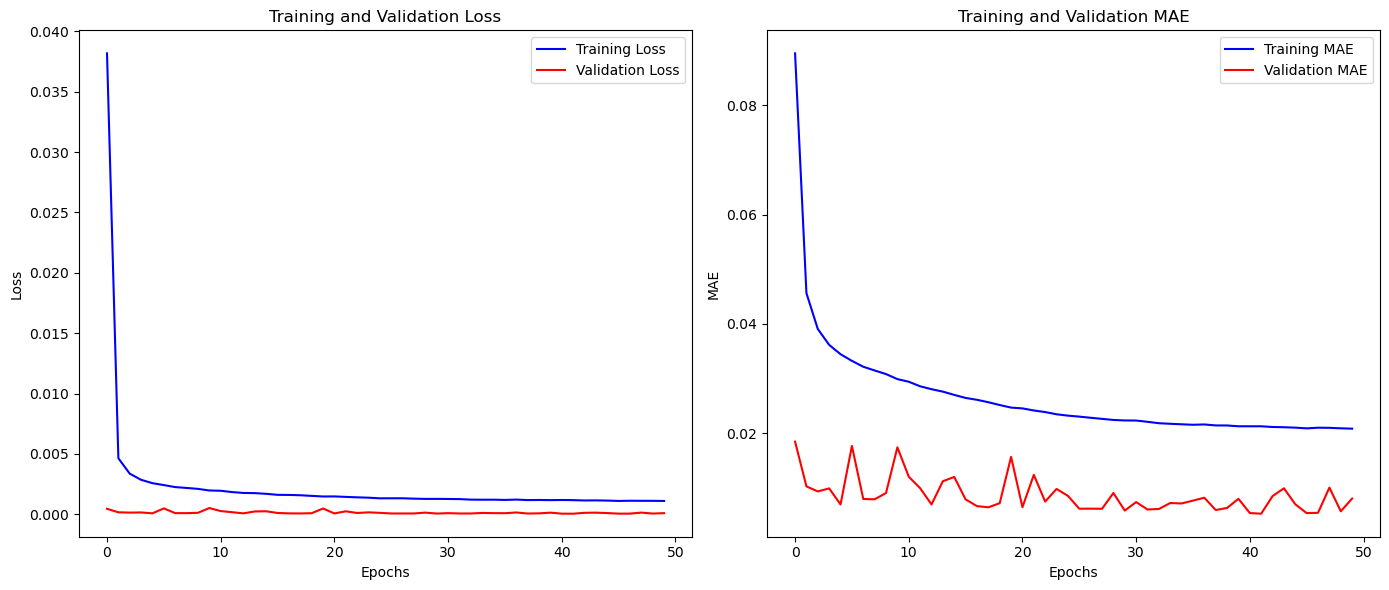

In [34]:
# Extract loss and metrics from the history object
train_loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']
train_mae = history_gru.history['mae']
val_mae = history_gru.history['val_mae']

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the loss
axs[0].plot(train_loss, label='Training Loss', color='blue')
axs[0].plot(val_loss, label='Validation Loss', color='red')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting the MAE
axs[1].plot(train_mae, label='Training MAE', color='blue')
axs[1].plot(val_mae, label='Validation MAE', color='red')
axs[1].set_title('Training and Validation MAE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend()

# Display the plot
plt.tight_layout()  # Automatically adjust the subplot parameters for better spacing
plt.savefig('final_model_generalisation.png', dpi=300)  # Save the plot
plt.show()

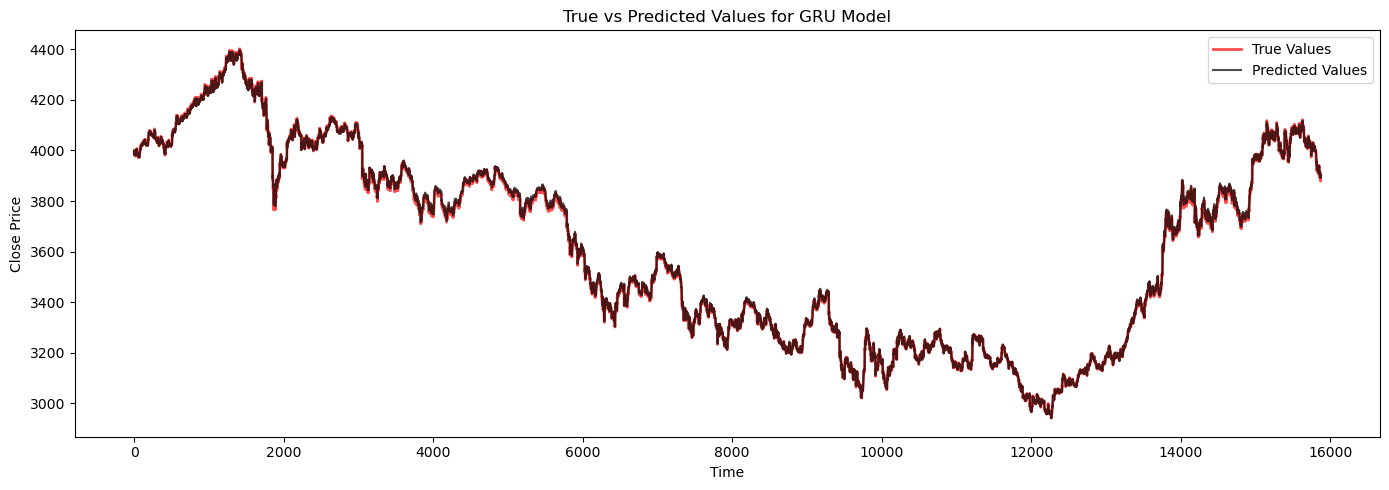

In [35]:
# Rescale predictions back to the original scale
predictions_rescaled = scaler.inverse_transform(np.hstack([np.zeros((y_pred.shape[0], 1)), y_pred]))[:, 1]

# Rescale the true values back to the original scale
y_test_rescaled = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], 1)), y_test.reshape(-1, 1)]))[:, 1]

# Initialize the plot
plt.figure(figsize=(14, 5))

# Plot the true values
plt.plot(y_test_rescaled, label='True Values', alpha=0.7, linewidth=2, color='red')

# Plot the predictions
plt.plot(predictions_rescaled, label='Predicted Values', alpha=0.7, color='black')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('True vs Predicted Values for GRU Model')

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig('final_model.png', dpi=300)  # Save the plot
plt.show()